# Time series analysis - Predicting a BJ model using the Kalman filter (see also code15).
**Lund University, Lund, Sweden**

**Note:** This is an IMPORTANT example!

**Note:** MATLAB uses a slightly different notation for the BJ model as compared to that used in the course. In MATLAB's notation:

A(z) y(t) = [B(z)/F(z)] u(t) + [C(z)/D(z)] e(t)

This means that:
- A(z) = 1,       B(z) = B(z),    F(z) = A2(z)
- C(z) = C1(z),   D(z) = A1(z)

**Reference:** "An Introduction to Time Series Modeling", 4th ed, by Andreas Jakobsson, Studentlitteratur, 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'TimeSeriesAnalysis-main', 'TimeSeriesAnalysis-main')))

from tsa_lth.analysis import plotACFnPACF, naive_pred, plotWithConf
from tsa_lth.modelling import estimateARMA, estimateBJ, polydiv

np.random.seed(1)
k = 1  # This is a one-step prediction.
extraN = 1000  # Let's check again why we do this; try removing this.
N = 1300
noLags = 30
modelLim = 1000  # Determine where the validation data starts.

## Simulate some process.

In [2]:
sX = 24
A1 = np.array([1, -0.9, 0.82])
C1 = np.array([1, 0, -0.8])
A3 = np.convolve(np.concatenate([[1], np.zeros(sX-1), [-1]]), [1, -0.4])
C3 = np.array([1, 0.8, 2.1])
B = np.array([1.2])
A2 = np.array([1])

z = signal.lfilter(C1, A1, np.random.randn(N + extraN))  # This is the noise model.
x = signal.lfilter(C3, A3, np.random.randn(N + extraN))  # This is the input signal.
y = signal.lfilter(B, A2, x) + z
y = y[extraN:]
x = x[extraN:]
xM = x[:modelLim]  # Extract model data.
yM = y[:modelLim]

## Examine the data.

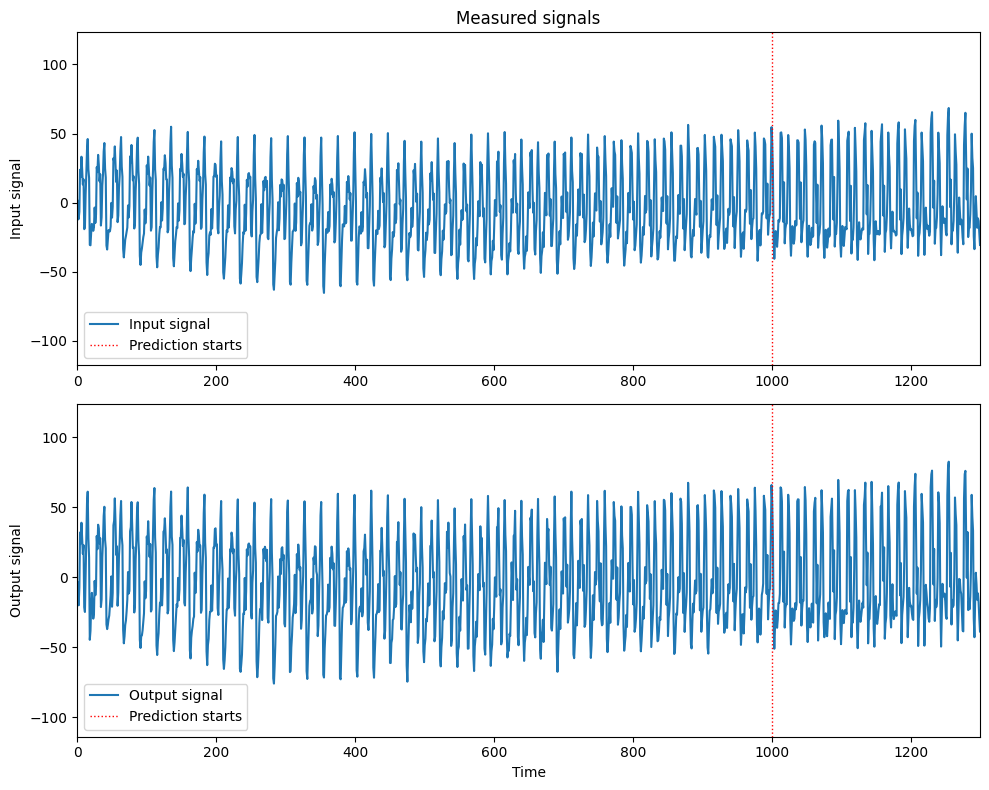

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(x)
ax1.axvline(x=modelLim-1, color='red', linestyle=':', linewidth=1)
ax1.set_xlim([0, N-1])
ax1.set_ylim([np.min(x)*1.8, np.max(x)*1.8])
ax1.set_ylabel('Input signal')
ax1.set_title('Measured signals')
ax1.legend(['Input signal', 'Prediction starts'], loc='lower left')

ax2.plot(y)
ax2.axvline(x=modelLim-1, color='red', linestyle=':', linewidth=1)
ax2.set_xlim([0, N-1])
ax2.set_ylim([np.min(y)*1.5, np.max(y)*1.5])
ax2.set_ylabel('Output signal')
ax2.set_xlabel('Time')
ax2.legend(['Output signal', 'Prediction starts'], loc='lower left')

plt.tight_layout()
plt.show()

## Create the BJ model.
For simplicity, we use the true model orders (see also code15).

Discrete-time ARMA model: A(z)y(t) = C(z)e(t)

A(z) = 1.0 - 0.377(±0.0462)·z⁻¹ - 0.9993(±0.0038)·z⁻²⁴ + 0.3754(±0.0463)·z⁻²⁵
C(z) = 1.0 + 0.393(±0.0415)·z⁻¹ + 0.4689(±0.0328)·z⁻²

Polynomial orders: nA = 25    nC = 2
Number of free coefficients: 5
Fit to estimation data (NRMSE): 92.19%
FPE : 4.605  MSE : 4.558
AIC : 4255.911   BIC : 4280.323



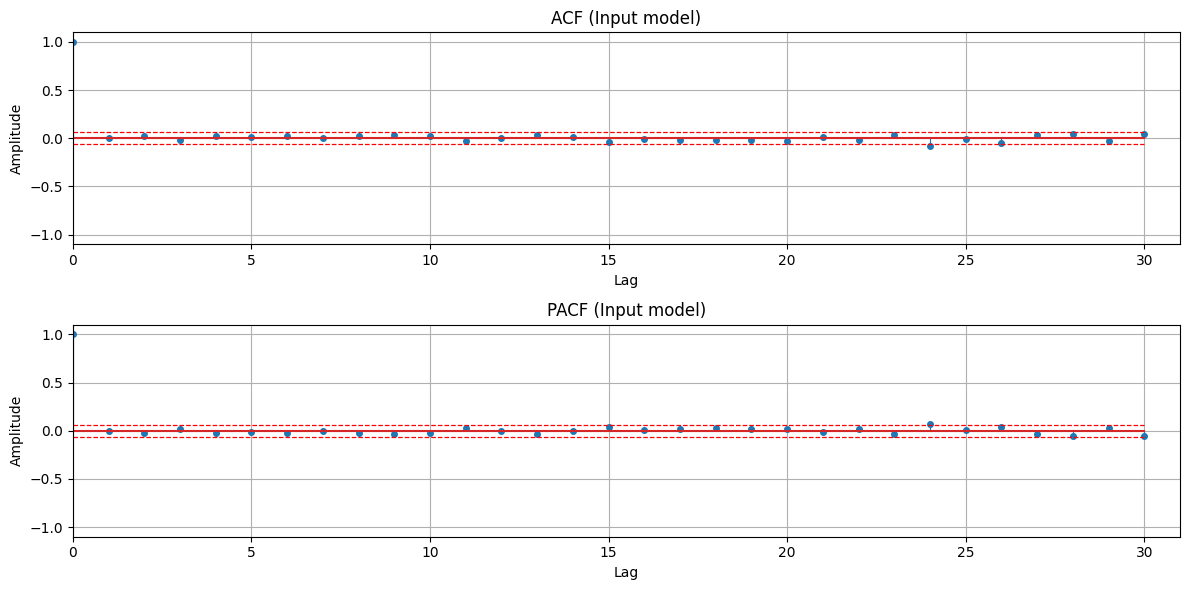

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 17.37 < 37.65)
  McLeod-Li test:        True (white if 28.22 < 37.65)
  Monti test:            True (white if 16.47 < 37.65)
  Sign change test:      False (white if 0.47 in [0.47,0.53])
Discrete-time BJ model: y(t) = B(z)x(t) + [C(z)/D(z)]e(t)

B(z) = 1.199(±0.0008)
C(z) = 1.0 - 0.0223(±0.0205)·z⁻¹ - 0.7679(±0.0205)·z⁻²
D(z) = 1.0 - 0.8989(±0.0186)·z⁻¹ + 0.8149(±0.0185)·z⁻²

Polynomial orders: nB = 0    nC = 2    nD = 2
Number of free coefficients: 5
Fit to estimation data (NRMSE): 96.82%
FPE : 1.108  MSE : 1.097
AIC : 2934.306   BIC : 2958.835



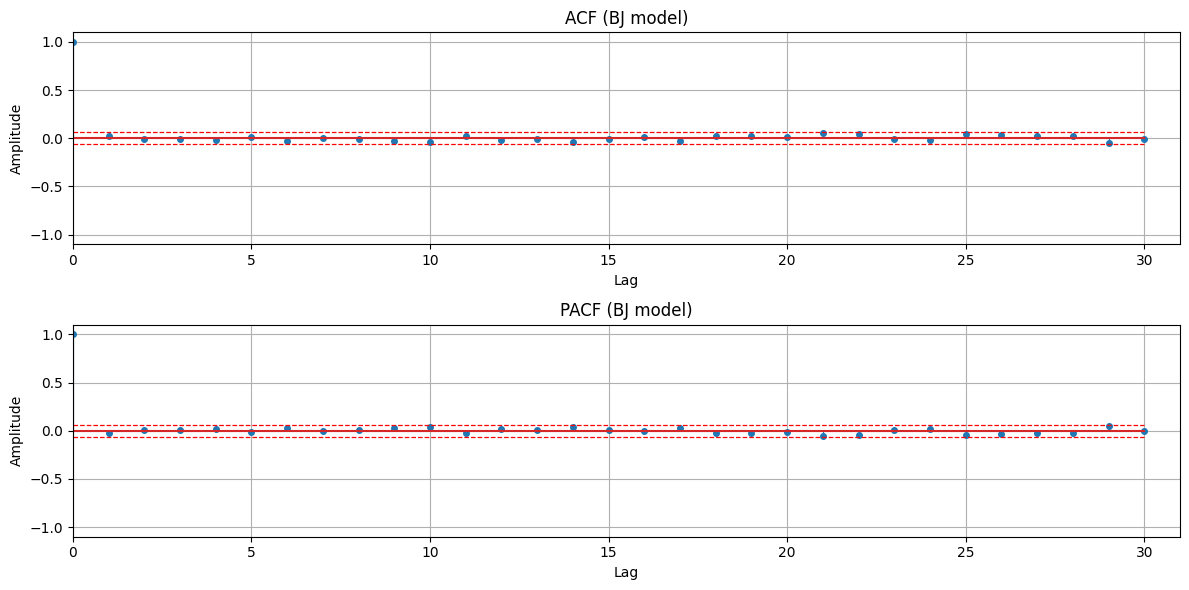

Whiteness test with 5.0% significance
  Ljung-Box-Pierce test: True (white if 15.72 < 37.65)
  McLeod-Li test:        True (white if 23.19 < 37.65)
  Monti test:            True (white if 16.07 < 37.65)
  Sign change test:      True (white if 0.50 in [0.47,0.53])


In [4]:
inputModel = estimateARMA(xM, A3, C3, titleStr='Input model', noLags=noLags, plot=True)
foundModel = estimateBJ(yM, xM, C1=C1, A1=A1, B=B, A2=A2, titleStr='BJ model', noLags=noLags)

## Predict the output using the found model.

In [5]:
Fx, Gx = polydiv(inputModel.C, inputModel.A, k)
xhatk = signal.lfilter(Gx, inputModel.C, x)

KA = np.convolve(foundModel.D, foundModel.F)
KB = np.convolve(foundModel.D, foundModel.B)
KC = np.convolve(foundModel.F, foundModel.C)
Fy, Gy = polydiv(foundModel.C, foundModel.D, k)
Fhh, Ghh = polydiv(np.convolve(Fy, KB), KC, k)
yhatP = signal.lfilter(Fhh, 1, xhatk) + signal.lfilter(Ghh, KC, x) + signal.lfilter(Gy, KC, y)
eP = y[modelLim:] - yhatP[modelLim:]  # Form the prediction residuals for the validation data.

## Estimate the unknown parameters using a Kalman filter and form the one-step prediction.

The ARMAX model is:

KA y(t) = KB x(t) + KC e(t)

This means, for our example, that the one-step prediction is formed as:

y(t+1) = -KA(2)y(t) - KA(3)y(t-1) + KB(1)x(t+1) + KB(2)x(t) + KB(3)x(t-1) + e(t+1) + KC(3)e(t-1)

       = [y(t) y(t-1) x(t+1) x(t) x(t-1) e(t-1)] [-KA(2) -KA(3) KB(1) KB(2) KB(3) KC(3)]^T + e(t+1)

Note that Python vectors start at index 0, therefore the first index in the A vector, A[0], is the same as we normally denote a₀. Furthermore, note that both x(t) and x(t-1) are known, whereas x(t+1) needs to be predicted if forming ŷ_{t+1|t}. In the first part below, we are forming the one-step prediction ŷ_{t|t-1} and comparing this to y(t) to compute the model error; in this case, we do know x(t) and can use that. Then, when forming ŷ_{t+1|t} in the latter part we cannot.

For illustration purposes, we consider three different cases; in the first version, we estimate the parameters of the input; in the second, we assume these to be fixed. In the third case, we modify the second case and examine if we can remove the KC parameter without losing too much performance.

In [6]:
codeVersion = 1

if codeVersion == 1:
    noPar = 6  # The vector of unknowns is [-KA(2) -KA(3) KB(1) KB(2) KB(3) KC(3)]
    xt = np.zeros((noPar, N))  # Estimated states. Set the initial state to the estimated parameters.
    xt[:, 1] = [KA[1], KA[2], KB[0], KB[1], KB[2], KC[2]]
elif codeVersion == 2:
    noPar = 3  # The vector of unknowns is [-KA(2) -KA(3) KC(3)]
    xt = np.zeros((noPar, N))  # Estimated states. Set the initial state to the estimated parameters.
    xt[:, 1] = [KA[1], KA[2], KC[2]]
elif codeVersion == 3:
    noPar = 2  # The vector of unknowns is [-KA(2) -KA(3)]
    xt = np.zeros((noPar, N))  # Estimated states. Set the initial state to the estimated parameters.
    xt[:, 1] = [KA[1], KA[2]]

A = np.eye(noPar)
Rw = np.std(eP)  # Measurement noise covariance matrix, R_w. Try using the noise estimate from the polynomial prediction.
Re = 1e-6 * np.eye(noPar)  # System noise covariance matrix, R_e.
Rx_t1 = 1e-4 * np.eye(noPar)  # Initial covariance matrix, R_{1|0}^{x,x}
Rx_k = Rx_t1.copy()
h_et = np.zeros(N)  # Estimated one-step prediction error.
yhat_t = np.zeros(N)  # One-step prediction ŷ_{t|t-1}
yhat_t1 = np.zeros(N)  # One-step prediction ŷ_{t+1|t}
xStd = np.zeros((noPar, N))  # Stores one std for the one-step prediction.
startInd = 2  # We use t-2, so start at t=2 (Python indexing, equivalent to t=3 in MATLAB)

for t in range(startInd, N-1):
    # Update the predicted state and the time-varying state vector.
    # For simplicity, we here use the earlier predicted inputs (in general,
    # this ought to also be predicted using a Kalman filter).
    x_t1 = A @ xt[:, t-1]  # x_{t|t-1} = A x_{t-1|t-1}
    
    if codeVersion == 1:  # Estimate all parameters.
        C = np.array([-y[t-1], -y[t-2], x[t], x[t-1], x[t-2], h_et[t-2]])
        yhat_t[t] = C @ x_t1
    elif codeVersion == 2:  # Note that KB does not vary in this case.
        C = np.array([-y[t-1], -y[t-2], h_et[t-2]])
        yhat_t[t] = C @ x_t1 + KB @ np.array([x[t], x[t-1], x[t-2]])
    elif codeVersion == 3:
        C = np.array([-y[t-1], -y[t-2]])  # Ignore one component.
        yhat_t[t] = C @ x_t1 + KB @ np.array([x[t], x[t-1], x[t-2]])
    
    # Update the parameter estimates.
    Ry = C @ Rx_t1 @ C.T + Rw  # R_{t|t-1}^{y,y} = C R_{t|t-1}^{x,x} + Rw
    Kt = Rx_t1 @ C.T / Ry  # K_t = R^{x,x}_{t|t-1} C^T inv( R_{t|t-1}^{y,y} )
    h_et[t] = y[t] - yhat_t[t]  # One-step prediction error, ê_t = y_t - ŷ_{t|t-1}
    xt[:, t] = x_t1 + Kt * h_et[t]  # x_{t|t} = x_{t|t-1} + K_t ( y_t - Cx_{t|t-1} )
    
    # Update the covariance matrix estimates.
    Rx_t = Rx_t1 - np.outer(Kt, Kt) * Ry  # R^{x,x}_{t|t} = R^{x,x}_{t|t-1} - K_t R_{t|t-1}^{y,y} K_t^T
    Rx_t1 = A @ Rx_t @ A.T + Re  # R^{x,x}_{t+1|t} = A R^{x,x}_{t|t} A^T + Re
    
    # Estimate a one std confidence interval of the estimated parameters.
    xStd[:, t] = np.sqrt(np.diag(Rx_t))  # This is one std for each of the parameters for the one-step prediction.
    
    # Form the one-step prediction ŷ_{t+1|t} = C_{t+1|t} A x_{t|t}.
    # Note that we in this case need to use the predicted inputs, xhatk.
    # For simplicity, we just use the polynomial prediction here - but this
    # should also be predicted using a Kalman filter.
    if codeVersion == 1:  # Estimate all parameters.
        Ck = np.array([-y[t], -y[t-1], xhatk[t+1], x[t], x[t-1], h_et[t-1]])
        yhat_t1[t+1] = Ck @ x_t1
    elif codeVersion == 2:  # Note that KB does not vary in this case.
        Ck = np.array([-y[t], -y[t-1], h_et[t-1]])
        yhat_t1[t+1] = Ck @ x_t1 + KB @ np.array([xhatk[t+1], x[t], x[t-1]])
    elif codeVersion == 3:
        Ck = np.array([-y[t], -y[t-1]])  # Ignore one component.
        yhat_t1[t+1] = Ck @ x_t1 + KB @ np.array([xhatk[t+1], x[t], x[t-1]])

print(f"Kalman filter estimation complete for code version {codeVersion}")

Kalman filter estimation complete for code version 1


## Examine the estimated parameters.

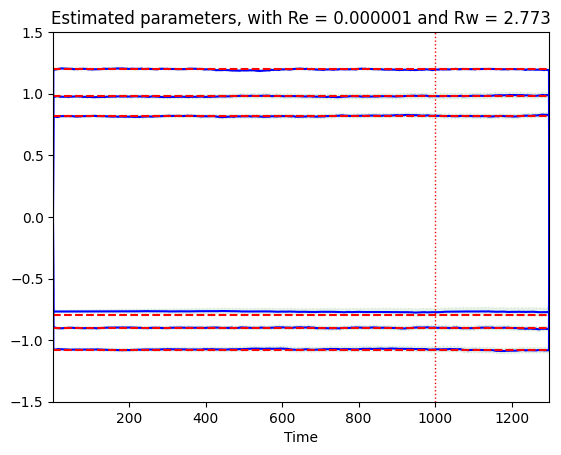

Using code version 1:
The final values of the Kalman estimated parameters are:
  True value: -0.90, estimated value: -0.91 (+/- 0.0185).
  True value:  0.82, estimated value:  0.83 (+/- 0.0185).
  True value:  1.20, estimated value:  1.19 (+/- 0.0087).
  True value: -1.08, estimated value: -1.08 (+/- 0.0222).
  True value:  0.98, estimated value:  0.99 (+/- 0.0221).
  True value: -0.80, estimated value: -0.77 (+/- 0.0340).



In [7]:
# Compute the true parameters for the KA, KB, and KC polynomials.
KA0 = np.convolve(A1, A2)
KB0 = np.convolve(A1, B)
KC0 = np.convolve(A2, C1)

if codeVersion == 1:
    trueParams = np.array([KA0[1], KA0[2], KB0[0], KB0[1], KB0[2], KC0[2]])
elif codeVersion == 2:
    trueParams = np.array([KA0[1], KA0[2], KC0[2]])
elif codeVersion == 3:
    trueParams = np.array([KA0[1], KA0[2]])

plotWithConf(np.arange(N), xt.T, xStd.T, trueParams)
plt.axvline(x=modelLim-1, color='red', linestyle=':', linewidth=1)
plt.xlim([startInd-1, N-1])
plt.ylim([-1.5, 1.5])
plt.title(f'Estimated parameters, with Re = {Re[0,0]:.6f} and Rw = {Rw:.3f}')
plt.xlabel('Time')
plt.show()

print(f'Using code version {codeVersion}:')
print('The final values of the Kalman estimated parameters are:')
for k0 in range(len(trueParams)):
    print(f'  True value: {trueParams[k0]:5.2f}, estimated value: {xt[k0, N-2]:5.2f} (+/- {xStd[k0, N-2]:5.4f}).')
print()

## Show the one-step prediction.
As the data is nice and stationary, the polynomial predictor works fine. Why not change one of the parameters when generating the validation data as we did in code21 and see how this affects the result?

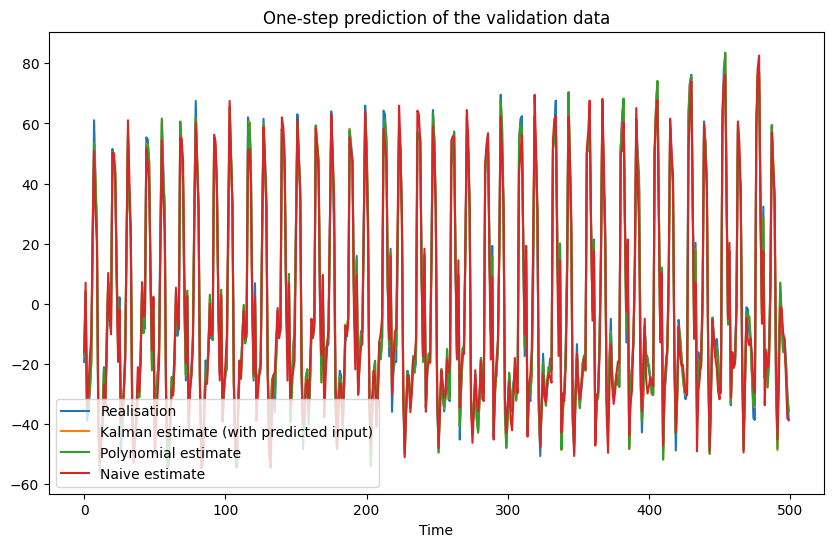

In [8]:
# Compute a naive estimate
testDataInd = np.arange(modelLim-200, N)
yNaive, var_naive, ehatN = naive_pred(y, testDataInd, k, season_k=sX)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(y[testDataInd], label='Realisation')
plt.plot(yhat_t1[testDataInd], label='Kalman estimate (with predicted input)')
plt.plot(yhatP[testDataInd], label='Polynomial estimate')
plt.plot(yNaive, label='Naive estimate')
plt.title('One-step prediction of the validation data')
plt.xlabel('Time')
plt.legend(loc='lower left')
plt.show()

## Form the prediction residuals for the validation data.

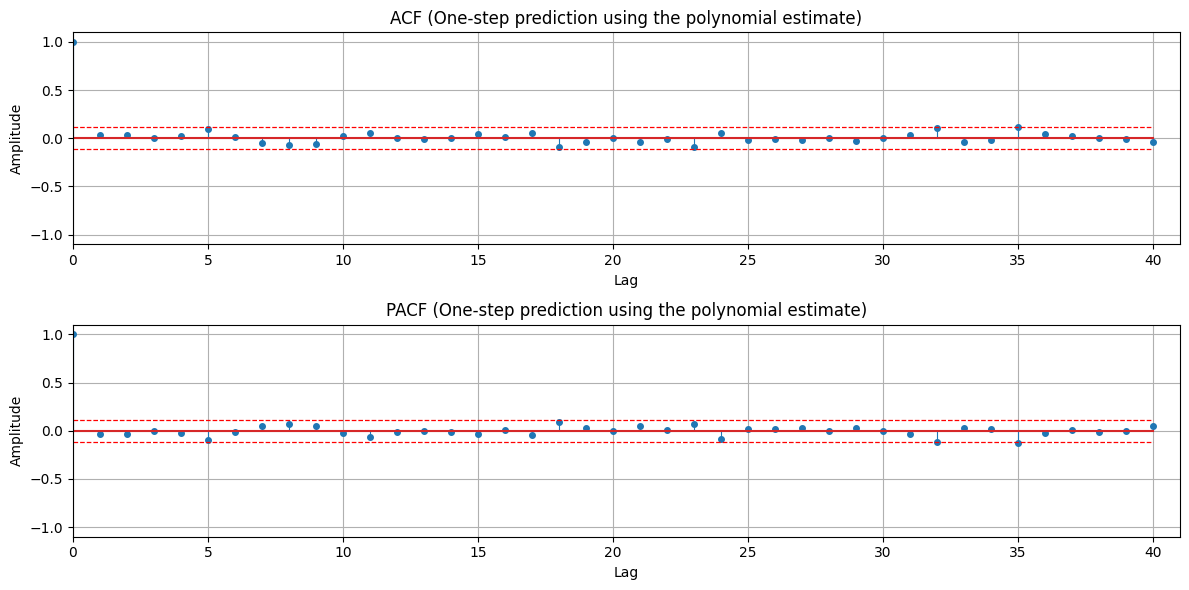

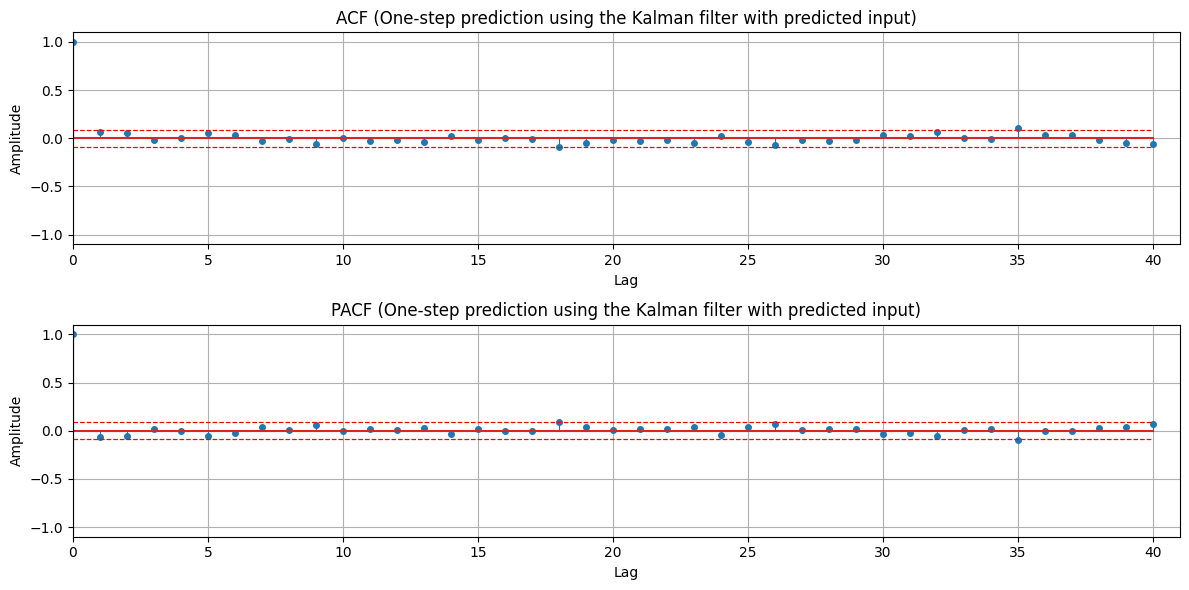

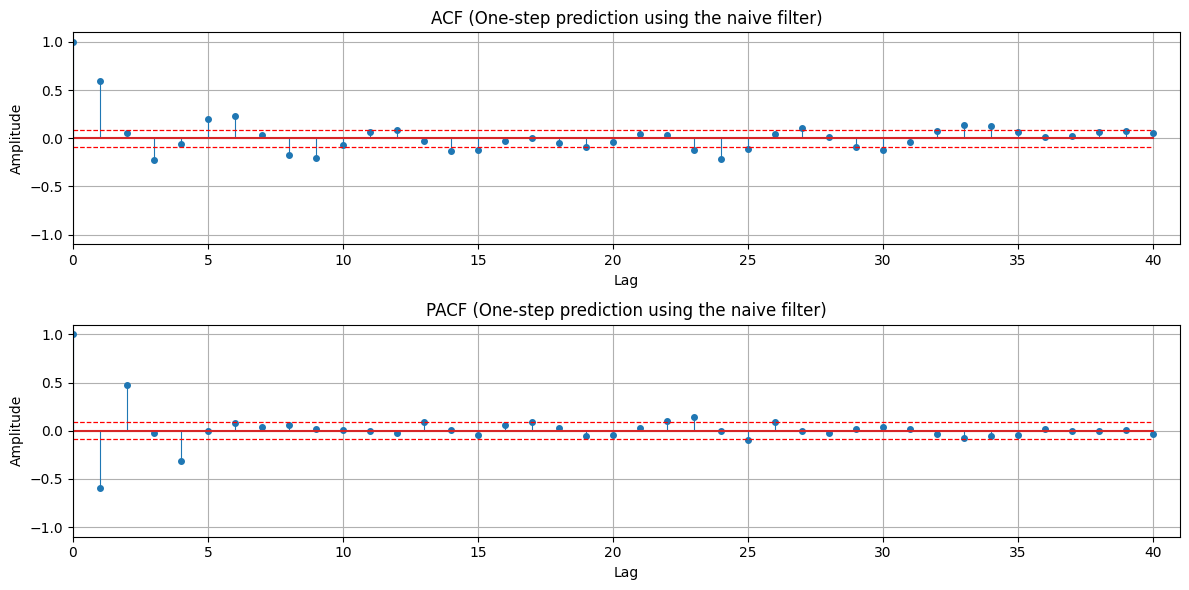

In [9]:
# Note here that as the Kalman filter allows the parameters to vary
varY = np.var(y[testDataInd])
eK = y[testDataInd] - yhat_t[testDataInd]  # One-step prediction with known input
eK1 = y[testDataInd] - yhat_t1[testDataInd]  # One-step prediction with predicted input

plotACFnPACF(eP, 40, titleStr='One-step prediction using the polynomial estimate')
plotACFnPACF(eK1, 40, titleStr='One-step prediction using the Kalman filter with predicted input')
plotACFnPACF(ehatN, 40, titleStr='One-step prediction using the naive filter')

In [10]:
print('Validation data:')
print(f'  Estimated variance: {np.var(y[modelLim:]):7.2f}\n')

print('The polynomial estimate:')
print(f'  Estimated variance: {np.var(eP):7.2f}')
print(f'  Explained variance:   {(1-np.var(eP)/varY)*100:3.2f}%\n')

print('The Kalman estimate at t (with known input):')
print(f'  Estimated variance: {np.var(eK):7.2f}')
print(f'  Explained variance:   {(1-np.var(eK)/varY)*100:3.2f}%\n')

print('The Kalman estimate at t+1 (predicting the input):')
print(f'  Estimated variance: {np.var(eK1):7.2f}')
print(f'  Explained variance:   {(1-np.var(eK1)/varY)*100:3.2f}%\n')

print('The naive estimate:')
print(f'  Estimated variance: {var_naive:7.2f}')
print(f'  Explained variance:   {(1-var_naive/varY)*100:3.2f}%\n')

Validation data:
  Estimated variance: 1288.63

The polynomial estimate:
  Estimated variance:    7.69
  Explained variance:   99.37%

The Kalman estimate at t (with known input):
  Estimated variance:    3.98
  Explained variance:   99.68%

The Kalman estimate at t+1 (predicting the input):
  Estimated variance:    7.95
  Explained variance:   99.35%

The naive estimate:
  Estimated variance:   31.22
  Explained variance:   97.46%

